In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.decomposition import tucker
from tensorly.tucker_tensor import tucker_to_tensor
from tensorly.tenalg import mode_dot, multi_mode_dot
import kagglehub
import h5py
from tqdm import tqdm
import pandas as pd
from utils import print_statistics, load_dataset, scale_and_center_tensors, create_hosvd_reconstruction_gif, analyze_pca_modes, plot_pca_spatial_modes
import global_variables 


In [2]:
n_snapshots = 200
subsample_x = 10
subsample_y = 10
paths = ["sharmapushan/hydrogen-jet-8000"]
data_paths = [kagglehub.dataset_download(name) for name in paths]
# Load metadata
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)
Nx, Ny = metadata['global']['Nxyz']
Nx_sub, Ny_sub = Nx//subsample_x, Ny//subsample_y
print(f"Original grid: ({Nx}, {Ny})")
print(f"Subsampled grid: ({Nx_sub}, {Ny_sub})")

Original grid: (1600, 2000)
Subsampled grid: (160, 200)


In [3]:
component_names = global_variables.component_names
n_species = global_variables.n_species
molar_masses = global_variables.molar_masses
file_key_map = global_variables.file_key_map
Lx, Ly = global_variables.Lx, global_variables.Ly

tensors = {path: load_dataset(path, component_names, file_key_map, Ny=Ny, Nx=Nx, n_snapshots=n_snapshots, molar_masses=molar_masses, subsample_x=10, subsample_y=10)
           for path in data_paths}

  Available components in dataset: ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']


In [4]:
tensors_scaled = scale_and_center_tensors(tensors, component_names, temporal_m=True)


CONTRIBUTING SPECIES FOR EACH PCA MODE - /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
 Mode   1st Species  2nd Species   3rd Species   4th Species  5th Species  6th Species  7th Species 8th Species
    1    YO (22.9%)  YOH (22.3%) YH2O2 (20.8%)  YHO2 (17.5%)  YH2O (8.4%)   YO2 (3.8%)   YH2 (3.0%)   YH (1.3%)
    2   YO2 (29.3%) YH2O (22.0%)  YHO2 (18.6%) YH2O2 (12.1%)   YOH (7.7%)   YH2 (5.9%)    YO (4.0%)   YH (0.5%)
    3   YH2 (40.8%)  YO2 (13.0%)  YH2O (12.3%)    YO (10.3%)  YHO2 (9.4%) YH2O2 (7.0%)   YOH (6.5%)   YH (0.5%)
    4 YH2O2 (20.9%)  YOH (16.1%)    YO (15.1%)   YO2 (13.6%)  YH2 (12.5%) YH2O (12.3%)  YHO2 (8.6%)   YH (0.8%)
    5  YH2O (25.6%) YHO2 (23.6%) YH2O2 (19.4%)   YO2 (11.8%)   YH2 (7.8%)   YOH (7.0%)    YH (2.6%)   YO (2.1%)
    6    YO (40.6%)  YOH (38.6%)    YO2 (9.0%)   YH2O (6.4%) YH2O2 (3.3%)  YHO2 (1.3%)   YH2 (0.5%)   YH (0.4%)
    7  YHO2 (21.4%)  YO2 (20.8%)  YH2O (17.2%) YH2O2 (17.0%)  YH2 (13.4%)   YOH (6.9%)    YO 

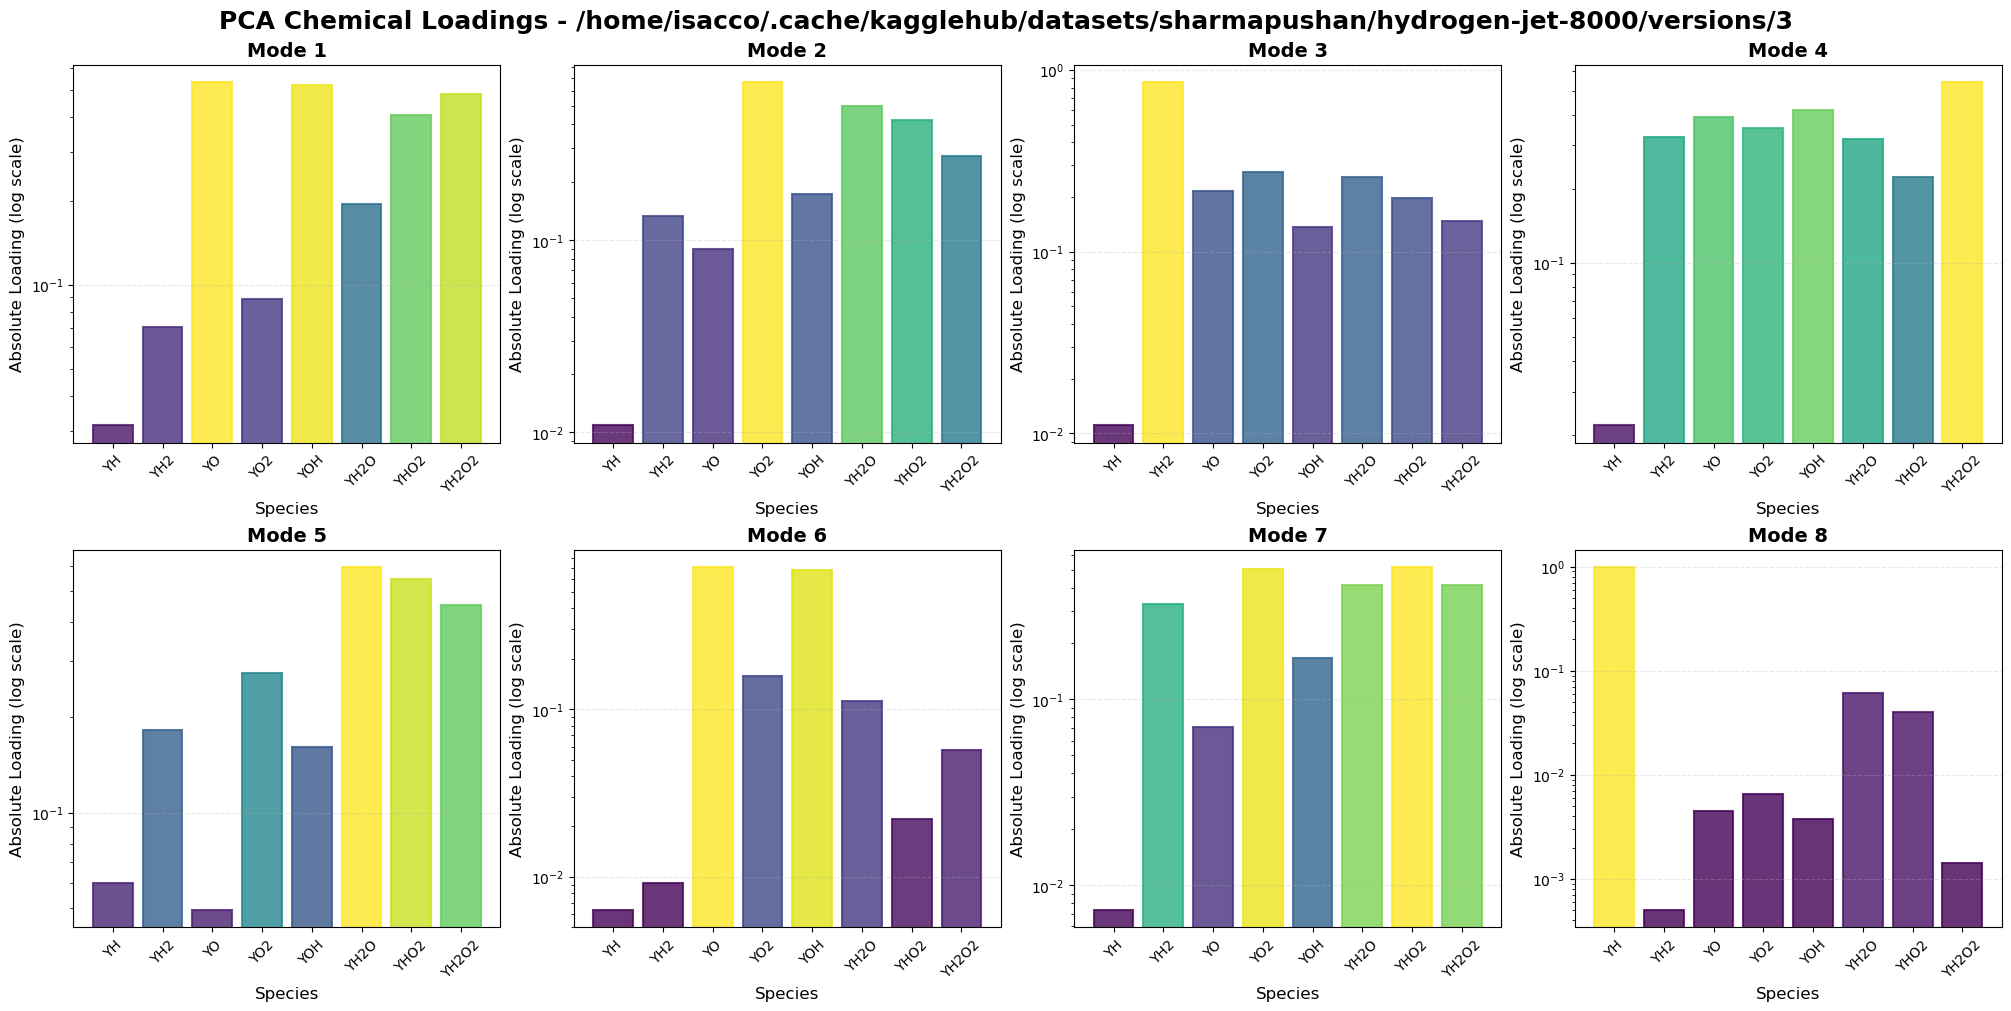

In [5]:
for dataset_path, tensor in tensors_scaled.items():
    X = np.moveaxis(tensor, 2, -1).reshape(tensor.shape[0]*tensor.shape[1]*tensor.shape[3], tensor.shape[2])
    U_PCA, sigma_PCA, V_PCA = np.linalg.svd(X, full_matrices=False)
    
    loadings = V_PCA.T  # Now shape is (n_components x n_modes)

df_PCA = analyze_pca_modes(loadings, component_names, dataset_path, n_top_species=8, visualize=True)

In [13]:
for dataset_path, tensor in tensors_scaled.items():
    print(f"\n=== Dataset: {dataset_path} ===")

    # Flatten and compute SVD
    X = np.moveaxis(tensor, 2, -1).reshape(tensor.shape[0]*tensor.shape[1]*tensor.shape[3], tensor.shape[2])
    U_PCA, sigma_PCA, V_PCA = np.linalg.svd(X, full_matrices=False)

    # Choose truncation level (you can change this)
    truncation_idx = min(10, len(sigma_PCA))  # example: 10 components

    # Reconstruct from truncated PCA
    X_reconstructed = (U_PCA[:, :truncation_idx] 
                       @ np.diag(sigma_PCA[:truncation_idx]) 
                       @ V_PCA[:truncation_idx, :])

    # Compute errors
    mse = np.mean((X - X_reconstructed) ** 2)
    mae = np.mean(np.abs(X - X_reconstructed))
    rel_err = np.linalg.norm(X - X_reconstructed) / np.linalg.norm(X)

    print(f"Truncation index: {truncation_idx}")
    print(f"MSE        : {mse:.4e}")
    print(f"MAE        : {mae:.4e}")
    print(f"Rel. Error : {rel_err:.4e}")

    # Optional: check explained variance
    explained_variance_ratio = np.cumsum(sigma_PCA**2) / np.sum(sigma_PCA**2)
    print(f"Explained variance by first {truncation_idx} modes: {explained_variance_ratio[truncation_idx-1]*100:.2f}%")



=== Dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3 ===
Truncation index: 8
MSE        : 1.2734e-28
MAE        : 3.9672e-15
Rel. Error : 1.4748e-14
Explained variance by first 8 modes: 100.00%


Phi shape: (6400000, 8)
Total spatial features: 6400000

Top modes energy content:
  Mode 1: 36.72%
  Mode 2: 28.39%
  Mode 3: 16.77%
  Mode 4: 6.05%
  Mode 5: 4.86%
  Mode 6: 4.03%
  Mode 7: 3.07%
  Mode 8: 0.10%


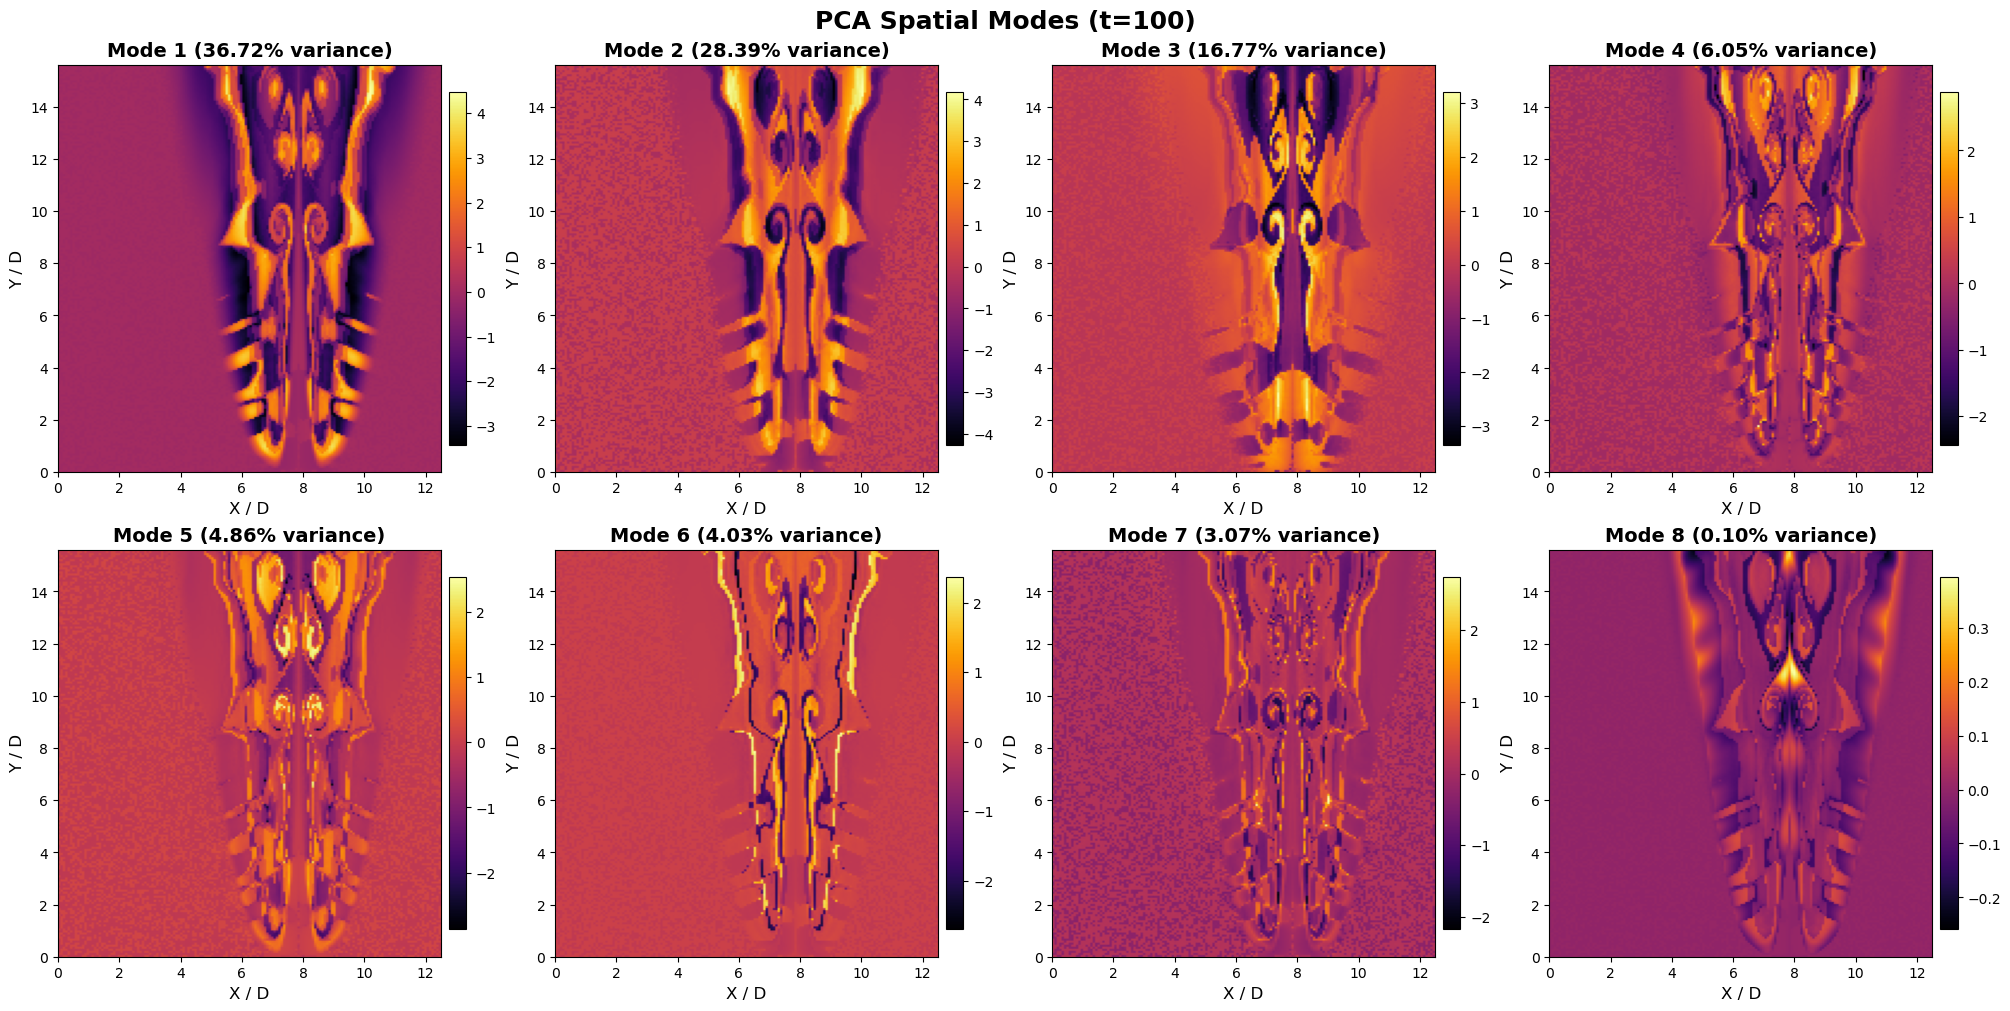

In [6]:
plot_pca_spatial_modes(U_PCA, sigma_PCA, V_PCA, Nx_sub, Ny_sub, n_modes=8, t_snapshot=100, Lx=12.5, Ly=15.6)

In [7]:
decomposition_results = {}  # store factors and cores per dataset

for dataset_path, tensor in tensors_scaled.items():
    print("\n" + "=" * 100)
    print(f"Performing HOSVD for dataset: {dataset_path}")
    print("=" * 100)
    
    factors = []
    for i in tqdm(range(tensor.ndim)):
        U, _, _ = np.linalg.svd(tl.unfold(tensor, mode=i), full_matrices=False)
        factors.append(U)

    core = multi_mode_dot(tensor, [U.T for U in factors], modes=range(tensor.ndim))
    print("done")
    reconst = multi_mode_dot(core, factors, modes=range(tensor.ndim))
    
    close = np.allclose(reconst, tensor)
    error = np.linalg.norm(np.subtract(reconst, tensor)) / np.linalg.norm(tensor)
    
    print(f"  Reconstruction close: {close}")
    print(f"  Relative reconstruction error: {error:.6e}")
    print("-" * 100)
    
    # store results
    decomposition_results[dataset_path] = {
        "core": core,
        "factors": factors,
    }
print("\n" + "=" * 100)


Performing HOSVD for dataset: /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3


100%|██████████| 4/4 [00:16<00:00,  4.16s/it]


done
  Reconstruction close: True
  Relative reconstruction error: 3.390656e-15
----------------------------------------------------------------------------------------------------



In [8]:
for idx, (key, f) in enumerate(decomposition_results.items()):
        core = f['core']
        U_x, U_y, U_chem, U_time = f['factors']
        dataset_name = f"Reynolds number {key.split("-")[-1][:4]}"


CONTRIBUTING SPECIES FOR EACH PCA MODE - /home/isacco/.cache/kagglehub/datasets/sharmapushan/hydrogen-jet-8000/versions/3
 Mode   1st Species  2nd Species   3rd Species   4th Species  5th Species  6th Species  7th Species 8th Species
    1    YO (22.9%)  YOH (22.3%) YH2O2 (20.8%)  YHO2 (17.5%)  YH2O (8.4%)   YO2 (3.8%)   YH2 (3.0%)   YH (1.3%)
    2   YO2 (29.3%) YH2O (22.0%)  YHO2 (18.6%) YH2O2 (12.1%)   YOH (7.7%)   YH2 (5.9%)    YO (4.0%)   YH (0.5%)
    3   YH2 (40.8%)  YO2 (13.0%)  YH2O (12.3%)    YO (10.3%)  YHO2 (9.4%) YH2O2 (7.0%)   YOH (6.5%)   YH (0.5%)
    4 YH2O2 (20.9%)  YOH (16.1%)    YO (15.1%)   YO2 (13.6%)  YH2 (12.5%) YH2O (12.3%)  YHO2 (8.6%)   YH (0.8%)
    5  YH2O (25.6%) YHO2 (23.6%) YH2O2 (19.4%)   YO2 (11.8%)   YH2 (7.8%)   YOH (7.0%)    YH (2.6%)   YO (2.1%)
    6    YO (40.6%)  YOH (38.6%)    YO2 (9.0%)   YH2O (6.4%) YH2O2 (3.3%)  YHO2 (1.3%)   YH2 (0.5%)   YH (0.4%)
    7  YHO2 (21.4%)  YO2 (20.8%)  YH2O (17.2%) YH2O2 (17.0%)  YH2 (13.4%)   YOH (6.9%)    YO 

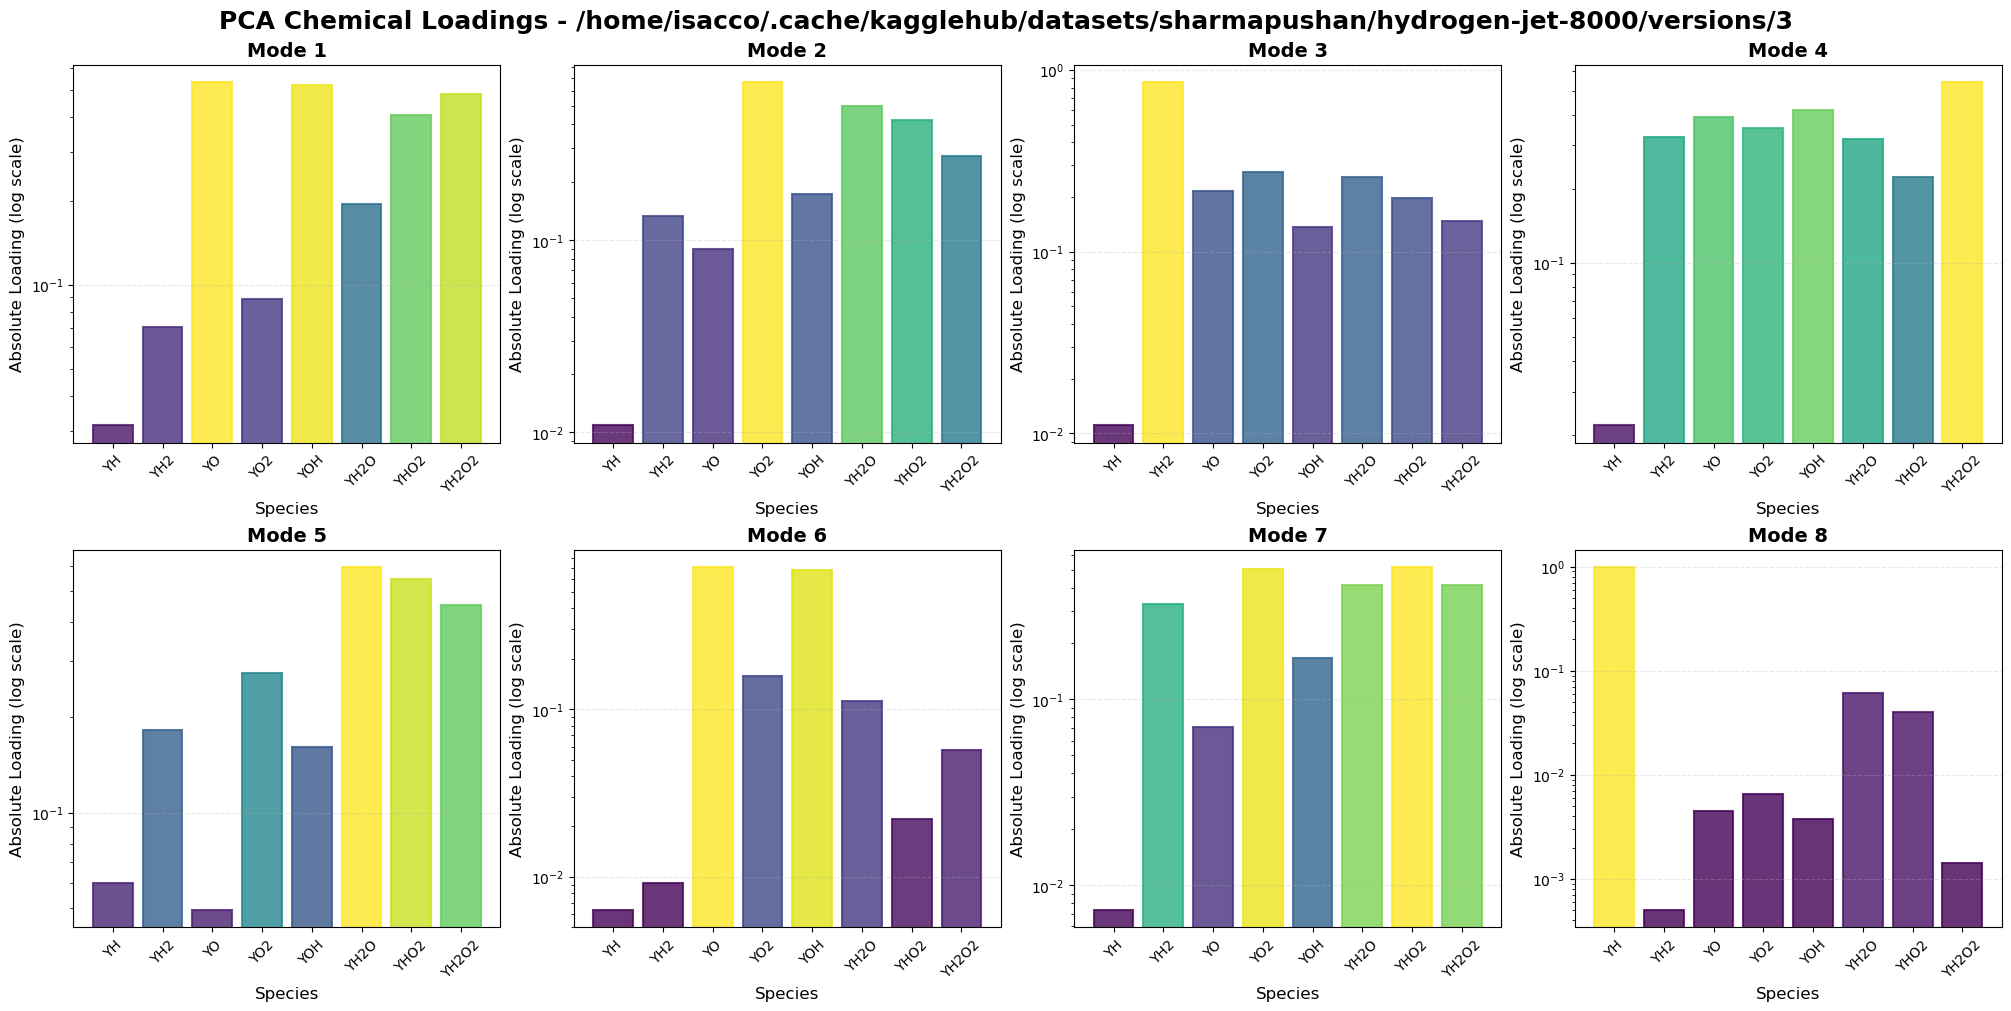

In [9]:
df_HOSVD = analyze_pca_modes(U_chem, component_names, dataset_path, n_top_species=8, visualize=True)

In [ ]:
def PCA_reconstruction(U_PCA, sigma_PCA, V_PCA, truncation_idx, Nx_sub = 160, Ny_sub = 200, n_species = 8, n_snapshots = 200):
    X_reconstructed =  U_PCA[:, :truncation_idx] @ np.diag(sigma_PCA[:truncation_idx]) @ V_PCA[:truncation_idx, :]
    # Reshape to intermediate shape (after moveaxis in forward pass)
    X_reconstructed = X_reconstructed.reshape(Nx_sub, Ny_sub, n_snapshots, n_species)
    # Move axis back to original order: species dimension from last to position 2
    return np.moveaxis(X_reconstructed, -1, 2)

reconst_PCA = PCA_reconstruction(U_PCA=U_PCA, sigma_PCA=sigma_PCA, V_PCA=V_PCA, truncation_idx=1)
plt.imshow(reconst_PCA[:,:, 0 ,10], origin='lower')

In [18]:
def HOSVD_reconstruction(decomposition_results, truncation_idx = 4):
    for idx, (key, f) in enumerate(decomposition_results.items()):
        core = f['core']
        U_x, U_y, U_chem, U_time = f['factors']
        dataset_name = f"Reynolds number {key.split("-")[-1][:4]}"
    return multi_mode_dot(core[:, :, :truncation_idx, :], [U_x, U_y, U_chem[:, :truncation_idx], U_time], modes= [i for i in range(4)])

reconst_HOSVD = HOSVD_reconstruction(decomposition_results=decomposition_results)

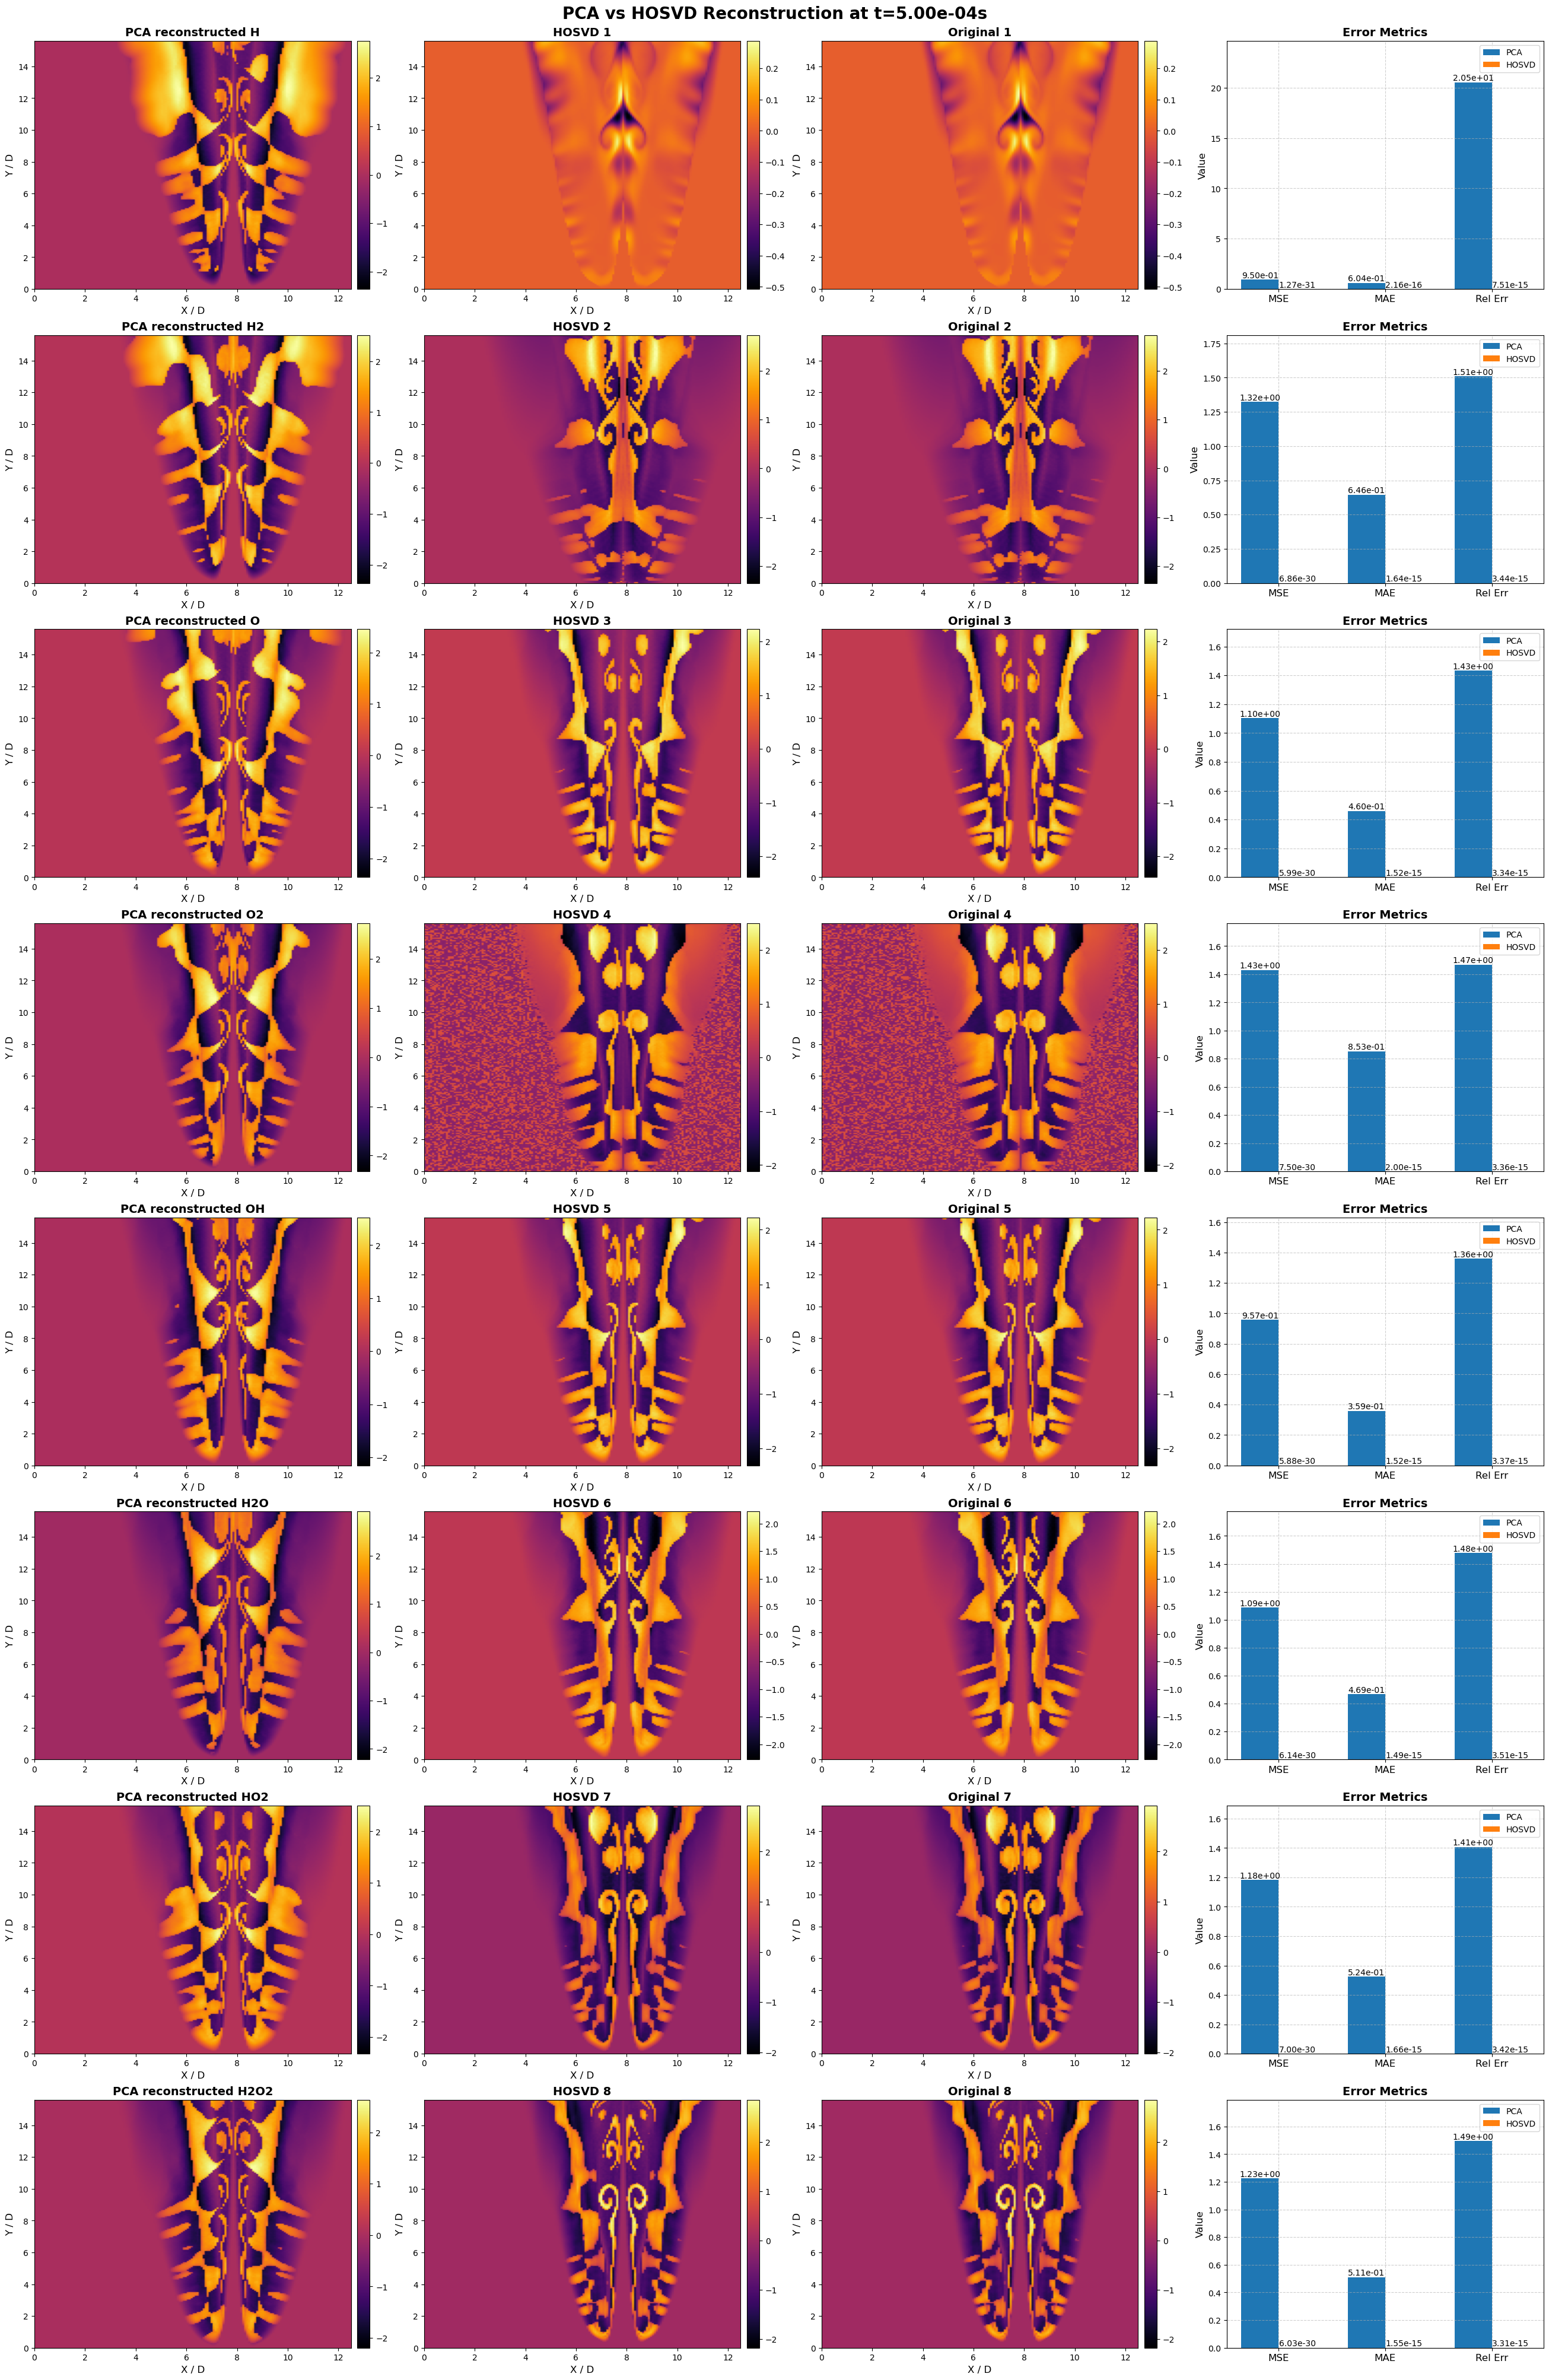

In [19]:
import numpy as np
import matplotlib.pyplot as plt

t_snapshot = 100
time_conversion_factor = 5e-06
truncation_idx = 8

# --- Reconstruction ---
fig, axes = plt.subplots(8, 4, figsize=(26, 40), constrained_layout=True)
fig.suptitle(
    f"PCA vs HOSVD Reconstruction at t={t_snapshot * time_conversion_factor:.2e}s", 
    fontsize=20, fontweight='bold'
)

reconstructed_HOSVD = HOSVD_reconstruction(decomposition_results, truncation_idx=truncation_idx)
reconstruction_PCA = PCA_reconstruction(U_PCA=U_PCA, sigma_PCA=sigma_PCA, V_PCA=V_PCA, truncation_idx=truncation_idx)

# --- Loop through species ---
for specie in range(n_species):
    # ========== PCA RECONSTRUCTION ==========
    ax = axes[specie, 0]
    snapshot_PCA = reconstruction_PCA[:, :, specie, t_snapshot]
    im = ax.imshow(snapshot_PCA, cmap='inferno', origin='lower', extent=[0, Lx, 0, Ly], aspect='auto')
    ax.set_title(f'PCA reconstructed {component_names[specie][1:]}', fontsize=14, fontweight='bold')
    ax.set_xlabel("X / D", fontsize=12)
    ax.set_ylabel("Y / D", fontsize=12)
    ax.tick_params(labelsize=10)
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02, fraction=0.046)
    cbar.ax.tick_params(labelsize=10)

    # ========== HOSVD RECONSTRUCTION ==========
    ax = axes[specie, 1]
    snapshot_HOSVD = reconstructed_HOSVD[:, :, specie, t_snapshot]
    im = ax.imshow(snapshot_HOSVD, cmap='inferno', origin='lower', extent=[0, Lx, 0, Ly], aspect='auto')
    ax.set_title(f'HOSVD {specie + 1}', fontsize=14, fontweight='bold')
    ax.set_xlabel("X / D", fontsize=12)
    ax.set_ylabel("Y / D", fontsize=12)
    ax.tick_params(labelsize=10)
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02, fraction=0.046)
    cbar.ax.tick_params(labelsize=10)

    # ========== ORIGINAL SNAPSHOT ==========
    ax = axes[specie, 2]
    snapshot_original = tensor[:, :, specie, t_snapshot]
    im = ax.imshow(snapshot_original, cmap='inferno', origin='lower', extent=[0, Lx, 0, Ly], aspect='auto')
    ax.set_title(f'Original {specie + 1}', fontsize=14, fontweight='bold')
    ax.set_xlabel("X / D", fontsize=12)
    ax.set_ylabel("Y / D", fontsize=12)
    ax.tick_params(labelsize=10)
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02, fraction=0.046)
    cbar.ax.tick_params(labelsize=10)
    # ========== ERROR METRICS ==========
    ax = axes[specie, 3]

    # Compute metrics
    mse_PCA = np.mean((snapshot_original - snapshot_PCA) ** 2)
    mse_HOSVD = np.mean((snapshot_original - snapshot_HOSVD) ** 2)
    mae_PCA = np.mean(np.abs(snapshot_original - snapshot_PCA))
    mae_HOSVD = np.mean(np.abs(snapshot_original - snapshot_HOSVD))
    rel_err_PCA = np.linalg.norm(snapshot_original - snapshot_PCA) / np.linalg.norm(snapshot_original)
    rel_err_HOSVD = np.linalg.norm(snapshot_original - snapshot_HOSVD) / np.linalg.norm(snapshot_original)

    # Organize data for side-by-side plotting
    metrics = ['MSE', 'MAE', 'Rel Err']
    pca_values = [mse_PCA, mae_PCA, rel_err_PCA]
    hosvd_values = [mse_HOSVD, mae_HOSVD, rel_err_HOSVD]

    x = np.arange(len(metrics))
    width = 0.35  # width of each bar

    # Plot side-by-side bars
    bars1 = ax.bar(x - width/2, pca_values, width, label='PCA', color='tab:blue')
    bars2 = ax.bar(x + width/2, hosvd_values, width, label='HOSVD', color='tab:orange')

    # Axis and labels
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, fontsize=12)
    ax.set_ylim(0, max(pca_values + hosvd_values) * 1.2)
    ax.set_title("Error Metrics", fontsize=14, fontweight='bold')
    ax.set_ylabel("Value", fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)

    # Add text labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2e}",
                    ha='center', va='bottom', fontsize=10)




plt.show()
